In [1]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs_3d
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt

import sys
# sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')

# from sparse_rrt import _deep_smp_module
# from params.cpp_dst_s32_e4 import get_params

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_line_3d(ax, p, p_index, color='b', alpha=1):
    for p_i in p_index:
        ax.plot3D(p[p_i, 0], p[p_i, 1], p[p_i, 2], c=color, alpha=alpha)

def centered_box_to_points_3d(center, size):
    half_size = [s/2 for s in size]
    direction, p = [1, -1], []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([center[di] + [x_d, y_d, z_d][di] * half_size[0] for di in range(3)])
    return p

def rot_frame_3d(state, frame_size=0.25):
    b, c, d, a = state[3:7]
    rot_mat = np.array([[2 * a**2 - 1 + 2 * b**2, 2 * b * c + 2 * a * d, 2 * b * d - 2 * a * c],
                        [2 * b * c - 2 * a * d, 2 * a**2 - 1 + 2 * c**2, 2 * c * d + 2 * a * b],
                        [2 * b * d + 2 * a * c, 2 * c * d - 2 * a * b, 2 * a**2 - 1 + 2 * d**2]])
    quadrotor_frame = np.array([[frame_size, 0, 0],
                                 [0, frame_size, 0],
                                 [-frame_size, 0, 0],
                                 [0, -frame_size, 0]]).T
    quadrotor_frame = rot_mat @ quadrotor_frame + state[:3].reshape(-1, 1)
    return quadrotor_frame

def q_to_points_3d(state):
    quadrotor_frame = rot_frame_3d(state)   
    max_min, direction = [np.max(quadrotor_frame, axis=1), np.min(quadrotor_frame, axis=1)], [1, 0]
    p = []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([max_min[x_d][0], max_min[y_d][1], max_min[z_d][2]])
    return np.array(p)

def draw_box_3d(ax, p, color='b', alpha=1, surface_color='blue', linewidths=1, edgecolors='k'):
    index_lists = [[[0, 4], [4, 6], [6, 2], [2, 0], [0, 1], [1, 5], [5, 7], [7, 3], [3, 1], [1, 5]],
                  [[4, 5]],
                  [[6, 7]],
                  [[2, 3]]]
    for p_i in index_lists:
        draw_line_3d(ax, np.array(p), p_i, color=color, alpha=alpha)
    edges = [[p[e_i] for e_i in f_i] for f_i in [[0, 1, 5, 4],
                                                 [4, 5, 7, 6],
                                                 [6, 7, 3, 2],
                                                 [2, 0, 1, 3],
                                                 [2, 0, 4, 6],
                                                 [3, 1, 5, 7]]]
    faces = Poly3DCollection(edges, linewidths=linewidths, edgecolors=edgecolors)
    faces.set_facecolor(surface_color)
    faces.set_alpha(0.1)
    ax.add_collection3d(faces)


def visualize_quadrotor_path(path, start_state, goal_state, obs_list, draw_bbox=True, width=1, savefig=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    counter = 0

    for obs in obs_list:
        draw_box_3d(ax, centered_box_to_points_3d(center=obs, size=[width]*3))
    
    ax.scatter(start_state[0], start_state[1], start_state[2], c='red')
    ax.scatter(goal_state[0], goal_state[1], goal_state[2], c='orange')
    draw_box_3d(ax, q_to_points_3d(start_state), alpha=0.3, surface_color="orange", linewidths=0.)
    draw_box_3d(ax, q_to_points_3d(goal_state), alpha=0.3, surface_color="orange", linewidths=0.)
    
    if path is not None:
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c='blue')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], c='blue')
        
        for waypoint in path:
            f = rot_frame_3d(waypoint)
            ax.scatter(f[0], f[1], f[2], color='red', s=10)
            ax.plot(f[0,[0, 2]], f[1, [0, 2]], f[2, [0, 2]], c='b')
            ax.plot(f[0,[1, 3]], f[1, [1, 3]], f[2, [1, 3]], c='b')

            if draw_bbox:
                draw_box_3d(ax, q_to_points_3d(waypoint), alpha=0.3, surface_color="orange", linewidths=0.)
    
            ax.set_xlim3d(-5, 5)
            ax.set_ylim3d(-5, 5)
            ax.set_zlim3d(-5, 5)
            if savefig:
                fig.savefig("figs/{}.png".format(counter))
            counter += 1
    
    return fig, ax

In [3]:
from mpnet.networks.mpnet_quadrotor_obs import MPNet
import torch

system = 'quadrotor_obs'
setup = 'default_norm'
# setup = 'default_norm_ss1'


# net_name = 'mpnet_l1_adam'
net_name = 'mpnet_l1_adagrad'
# net_name = 'mpnet'


ep = 75
mpnet = MPNet(ae_input_size=32, ae_output_size=64, in_channels=32, state_size=13)
mpnet.load_state_dict(torch.load('mpnet/output/{}/{}/{}/ep{}.pth'.format(system, setup, net_name, ep)))
mpnet.cuda()
mpnet.train()
# mpnet.eval()

env_vox_all = torch.from_numpy(np.load('mpnet/sst_envs/data/{}_env_vox.npy'.format(system))).float()

def plan(start_th, goal_th, env_vox, mpnet):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = mpnet(start_goal, env_vox)         
    return sample.clone()

In [4]:
def vis_pointwise(env_id = 0, traj_id = 900, mpnet=None):
    path_dict = load_data('quadrotor_obs', env_id, traj_id)
    path = path_dict['path']

#     goal_th = torch.from_numpy(path_dict['path'][-1])

    goal_th = torch.from_numpy(path_dict['start_goal'][-1])
    goal_th[:4] /= 5
    goal_th = goal_th.unsqueeze(0).cuda()

    env_vox = env_vox_all[env_id, :, :, :].unsqueeze(0).cuda()

    samples = []

    for node in path:
        n = node.copy()
        n[:3] /= 5
        state = torch.from_numpy(n).unsqueeze(0).cuda()
        sample = plan(state, goal_th, env_vox, mpnet)
        sample[:, :3] *= 5
        samples.append(sample[0].cpu().numpy())
    samples = np.array(samples)

    fig, ax = visualize_quadrotor_path(path, 
                                       path_dict['start_goal'][0],
                                       path_dict['start_goal'][-1], 
                                       obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id], 
                                       )
    for i in range(len(path)):
        ax.plot([path[i][0], samples[i][0]], 
                [path[i][1], samples[i][1]],
                [path[i][2], samples[i][2]],
                  c='orange')

In [5]:
%matplotlib notebook
mpnet.eval()
vis_pointwise(env_id = 0, traj_id = 900, mpnet=mpnet)

<IPython.core.display.Javascript object>

In [6]:
def vis_connect(env_id = 0, traj_id = 900, mpnet=None, ax=plt, path_dict=None, c='orange'):
#     goal_th = torch.from_numpy(path[-1][:].copy())
#     print(path[-1][:], path_dict['start_goal'][-1])
    goal_th = torch.from_numpy(path_dict['start_goal'][1].copy())
    
    goal_th[:3] /= 5
    goal_th = goal_th.unsqueeze(0).cuda()
#     print("goal:", goal_th)
    env_vox = env_vox_all[env_id, :, :, :].unsqueeze(0).cuda()


    state = torch.from_numpy(path_dict['start_goal'][0].copy()).unsqueeze(0).cuda()
#     state = torch.from_numpy(path_dict['path'][-5].copy()).unsqueeze(0).cuda()
    state[:, :3] /= 5
    samples = []

    samples.append(state[0].cpu().numpy())

    for i in range(20):
        sample = plan(state, goal_th, env_vox, mpnet)
        state = sample
#         print(state)
        samples.append(state[0].cpu().numpy())
    samples = np.array(samples)
#     print(samples)

    samples[:, :3] *= 5

    for i in range(len(samples)-1):
        ax.plot([samples[i][0], samples[i+1][0]], 
                [samples[i][1], samples[i+1][1]],
                [samples[i][2], samples[i+1][2]], c=c)
        ax.scatter([samples[i][0], samples[i+1][0]], 
                   [samples[i][1], samples[i+1][1]],
                   [samples[i][2], samples[i+1][2]],c=c)
    return samples

In [7]:
%matplotlib notebook
# mpnet.eval()
mpnet.train()


env_id = 0
traj_id = 950

path_dict = load_data('quadrotor_obs', env_id, traj_id)
path = path_dict['path'].copy()

fig, ax = visualize_quadrotor_path(path, 
                                   path_dict['start_goal'][0],
                                   path_dict['start_goal'][-1], 
                                   obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id])
# for color in ['red', 'blue', 'orange', 'yellow', 'green']:
#     print(vis_connect(env_id, traj_id, mpnet, ax=ax, path_dict=path_dict, c=color)[-1])

p = vis_connect(env_id, traj_id, mpnet, ax=ax, path_dict=path_dict)
# print(p)


<IPython.core.display.Javascript object>

In [86]:
from matplotlib import pyplot as plt
import numpy as np

system = 'sst_envs'
setup = 'default_norm'
model = 'quadrotor_obs'

data_set = np.load('mpnet/{system}/data/{setup}/{model}_path_data.npy'.format(system=system, setup=setup, model=model))
gt = np.load('mpnet/{system}/data/{setup}/{model}_gt.npy'.format(system=system, setup=setup, model=model))

data_set.shape, gt.shape

((1185210, 27), (1185210, 13))

<IPython.core.display.Javascript object>


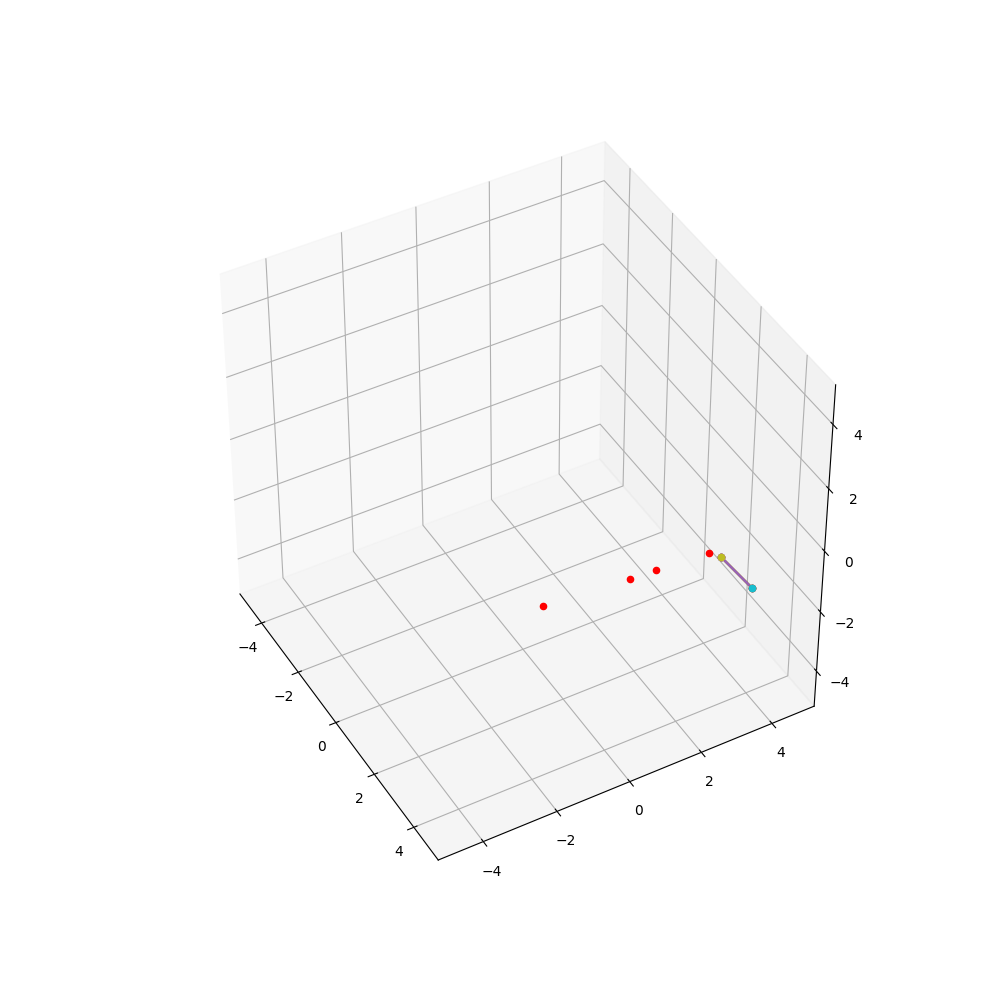

[ 3.78284828  4.17397537 -1.91296848] [ 3.21896285  3.60105317 -1.06615977]
[ 3.78284828  4.17397537 -1.91296848] [ 3.21896285  3.60105317 -1.06615977]
[ 3.78284828  4.17397537 -1.91296848] [ 3.21896285  3.60105317 -1.06615977]
[ 3.78284828  4.17397537 -1.91296848] [ 3.21896285  3.60105317 -1.06615977]
[ 3.78284828  4.17397537 -1.91296848] [ 3.21896285  3.60105317 -1.06615977]


(-5.0, 5.0)

In [89]:
%matplotlib notebook

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(5):
    s= data_set[i].copy()[1:]
#     print(s.shape)
    g = gt[i].copy()
    s[:3] *= 5
    g[:3] *= 5
    
    print(s[:3],g[:3])
    ax.scatter(s[13]*5, s[14]*5, s[15]*5, c='red')

    ax.scatter(g[0], g[1], g[2])
    ax.scatter(s[0], s[1], s[2])
    ax.plot([s[0], g[0]], [s[1], g[1]], [s[2], g[2]])
ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-5, 5)

In [79]:
data_set[0, 1:4], gt[0, :3], data_set[1, 1:4], gt[0, :3], data_set[1, 1:4]

(array([ 0.03615266, -0.91534456, -0.78604324]),
 array([ 0.73660292, -0.03420354,  0.44190573]),
 array([ 0.03615266, -0.91534456, -0.78604324]),
 array([ 0.73660292, -0.03420354,  0.44190573]),
 array([ 0.03615266, -0.91534456, -0.78604324]))

In [7]:
path_dict = load_data('quadrotor_obs', 0, 0)
path = path_dict['path']
path_dict['cost']

array([0.998, 0.2  , 0.914, 0.446, 0.736, 0.732, 0.13 ])

In [8]:
path_dict['cost'].sum()

4.156000000000001